In [1]:
import os
import gc
import re
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, Pool

# Suppress PerformanceWarning
warnings.filterwarnings("ignore")


## Load data

Prior to loading the data, we identify and categorize columns with string data types in the dataset. Additionally, it selects columns from the 'V' category, focusing on those that exhibit meaningful relationships with the target variable as revealed through correlation-based exploratory data analysis (EDA). By doing so, the code aims to streamline the dataset to include only the most relevant 'V' columns, optimizing computational efficiency and model performance during subsequent analysis and modeling phases. 

EDA for D and M columns will be continued in the code below. 

In [2]:
# FIRST 53 COLUMNS
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

cols_v = ['V'+str(x) for x in range(1,340)]; 
types_v = {}

for c in cols_v: 
    types_v[c] = 'float32'
    
train = pd.read_csv('./train_transaction.csv',usecols=cols_t+['isFraud']+cols_v,dtype=types_v)
train = train.reset_index(drop=True)
train.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## We look at the NaNs distribution for all V columns

From our initial data analysis, we see that many columns have NaNs, and some columns have NaNs at the same position, there might be some link between these columns, thus we will be looking into it.

We have removed columns that have NaN of more than 70% as high occurrence of missing values in a dataset can introduce bias by distorting the relationships between features, potentially resulting in inaccurate predictions. This bias can arise due to the loss of representative data, distorted data patterns, overreliance on available information, and unintended associations between variables. 

From the NAN analysis, we can see the following NAN structure for the following columns:

####### NAN count = 0 
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

####### NAN count = 12 
['V279', 'V280', 'V284', 'V285', 'V286', 'V287', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']

####### NAN count = 314 
['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']

####### NAN count = 1269 
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']

####### NAN count = 76073 
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']

####### NAN count = 77096
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']

####### NAN count = 89164
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']

####### NAN count = 168969
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']

####### NAN count = 279287 
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

####### NAN count = 449124 
['V220', 'V221', 'V222', 'V227', 'V234', 'V238', 'V239', 'V245', 'V250', 'V251', 'V255', 'V256', 'V259', 'V270', 'V271', 'V272']

####### NAN count = 450721
['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']

####### NAN count = 450909
['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']

####### NAN count = 460110
['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']

####### NAN count = 508189
['V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

####### NAN count = 508589
['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']

####### NAN count = 508595
['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']


In [3]:
nans_df = train.isna()
nans_groups={}
i_cols = ['V'+str(i) for i in range(1,340)]
threshold = int(len(train)*0.7) # max number of NaNs we can accept
selected_groups = []

for col in train.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k, v in nans_groups.items():
    if k < threshold:
        selected_groups.append(v) 
    
    print('####### NAN count =', k)
    print(v)

for k, v in sorted(nans_groups.items()):
    print('####### NAN count =', k)
    print(v)

####### NAN count = 0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 1577
['card4']
####### NAN count = 4259
['card5']
####### NAN count = 1571
['card6']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 94456
['P_emaildomain']
####### NAN count = 453249
['R_emaildomain']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
####### NAN count = 280797
['D2']
####### NAN count = 262878
['D3']
####### NAN count = 168922
['D4']
####### NAN count = 309841
['D5']
####### NAN count = 517353
['D6']
####### NAN count = 551623
['D7']
####### NAN count = 515614
['D8', 'D9']
####### NAN count = 76022
['D10']
####### NAN count = 27

In [4]:
# We want to get groups with similar NAN counts and do a check for them
# We only want to select groups with V columns

nans_group = [i for i in selected_groups if len(i) > 3]
del nans_group[0], selected_groups # remove the first row which contains categorical values
print(nans_group)

[['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315'], ['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11'], ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34'], ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52'], ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74'], ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'], ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', '

## Finding the best column within highly correlated groups

For each group generated above, we will be doing a correlation matrix to show and find columns that are highly correlated with each other. 

For example, we have one nested list which will be ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']

For columns that are highly correlated with one another, we will nest these columns together to become like [['V12', 'V13'], ['V14'], ['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'], ['V19', 'V20'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30']]

Within each nested list, there are variables that exhibit strong correlations with each other, having a correlation coefficient greater than 0.7. The objective is to reduce the number of variables utilized to prevent overfitting and potential bias in the model. To achieve this, for each group of highly correlated variables, we aim to retain the one that provides the most valuable information. In this context, "valuable information" is defined by the variable with the highest number of unique values. It's worth noting that within each group, all columns contain the same number of NaNs, so the selection is based solely on the number of unique non-NaN values. As a result, we end up with a list of columns that are deemed most informative, which includes ['V13', 'V14', 'V34', 'V20', 'V24', 'V26', 'V28', 'V30'].

Cols with same number of NaNs: ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']

Cols that are highly corrlated to each other: [['V12', 'V13'], ['V14'], ['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'], ['V19', 'V20'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30']]

Selected columns: ['V13', 'V14', 'V34', 'V20', 'V24', 'V26', 'V28', 'V30']


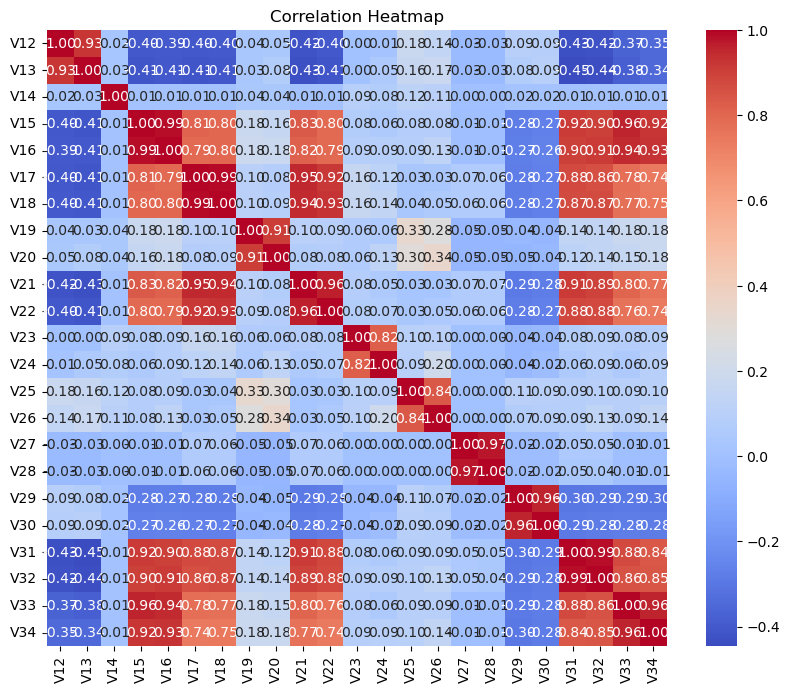

In [5]:
# Define functions

def find_correlation_groups(correlation_matrix, correlation_threshold=0.7):
    # Create an empty list to store the grouped items
    correlation_groups = []

    # Create a set to keep track of columns that have been included in a group
    used_columns = set()

    # Iterate through the correlation matrix
    for col1 in correlation_matrix.columns:
        # Check if col1 is already in any group or has been used
        if col1 in used_columns:
            continue

        # Create a new group starting with col1
        group = [col1]
        used_columns.add(col1)

        # Iterate through other columns to find correlated items
        for col2 in correlation_matrix.columns:
            if col1 != col2 and col2 not in used_columns:  # Exclude self-correlation and used columns
                correlation_value = correlation_matrix.loc[col1, col2]
                if correlation_value >= correlation_threshold:
                    group.append(col2)
                    used_columns.add(col2)
        # Add the group to the list of groups
        correlation_groups.append(group)
    return correlation_groups

def reduce_groups(groups):
    res = []
    for group in groups: # ['V2', 'V3']
        for col in group:
            curr_max = 0
            best_col = group[0]
            n = train[col].nunique()
            if n > curr_max:
                curr_max = n
                best_col = col         
        res.append(best_col)
    return res           

group_df = train[nans_group[2]]
correlation_matrix = group_df.corr()

print("Cols with same number of NaNs:", nans_group[2])
# Define the correlation threshold
correlation_threshold = 0.7

# Find correlated groups
correlation_groups = find_correlation_groups(correlation_matrix, correlation_threshold)
print("\nCols that are highly corrlated to each other:", correlation_groups)

reduced_groups = reduce_groups(correlation_groups)
print("\nSelected columns:", reduced_groups)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Cols with same number of NaNs: ['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']

Cols that are highly corrlated to each other: [['D1'], ['V281'], ['V282', 'V283'], ['V288', 'V289'], ['V296'], ['V300', 'V301'], ['V313', 'V314', 'V315']]

Selected columns: ['D1', 'V281', 'V283', 'V289', 'V296', 'V301', 'V315']


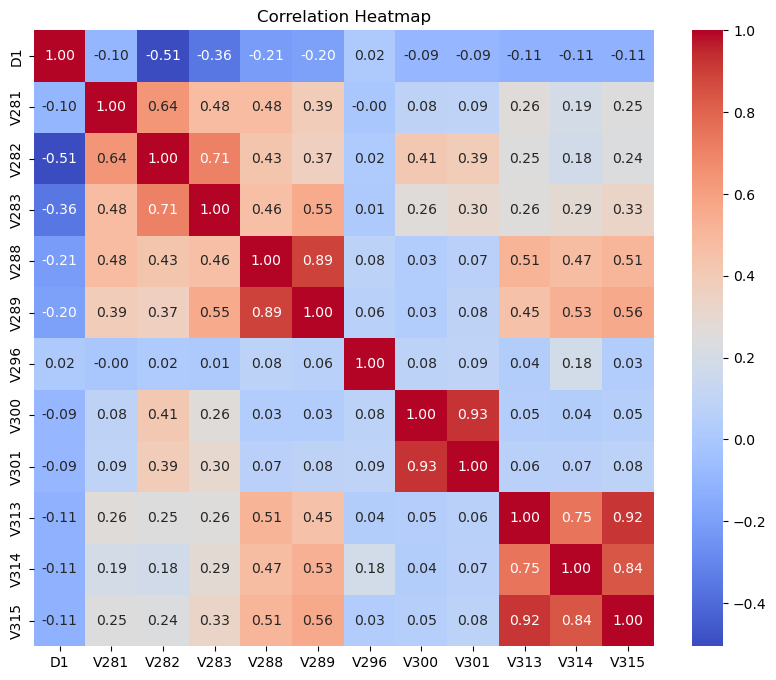

Cols with same number of NaNs: ['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

Cols that are highly corrlated to each other: [['D11'], ['V1'], ['V2', 'V3', 'V8'], ['V4', 'V5'], ['V6', 'V7'], ['V9'], ['V10', 'V11']]

Selected columns: ['D11', 'V1', 'V8', 'V5', 'V7', 'V9', 'V11']


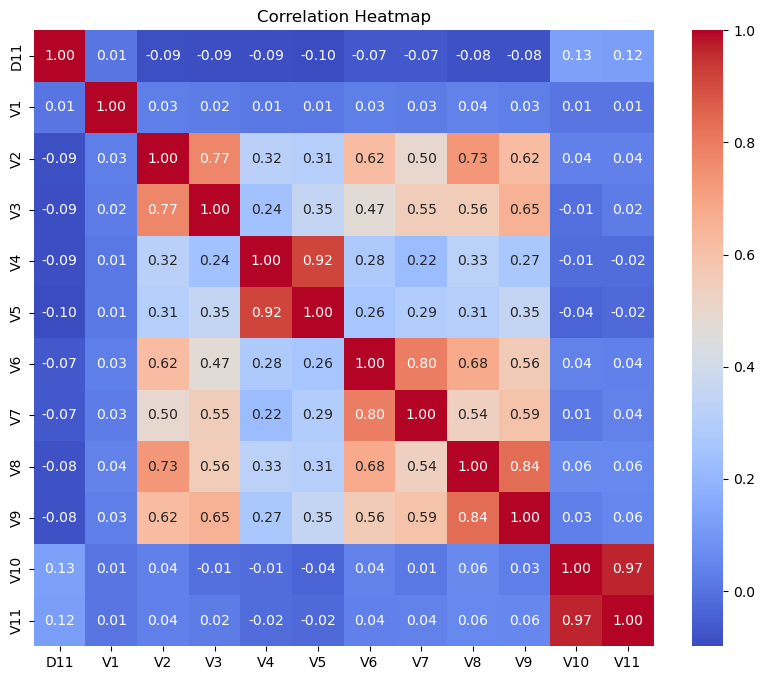

Cols with same number of NaNs: ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']

Cols that are highly corrlated to each other: [['V12', 'V13'], ['V14'], ['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'], ['V19', 'V20'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30']]

Selected columns: ['V13', 'V14', 'V34', 'V20', 'V24', 'V26', 'V28', 'V30']


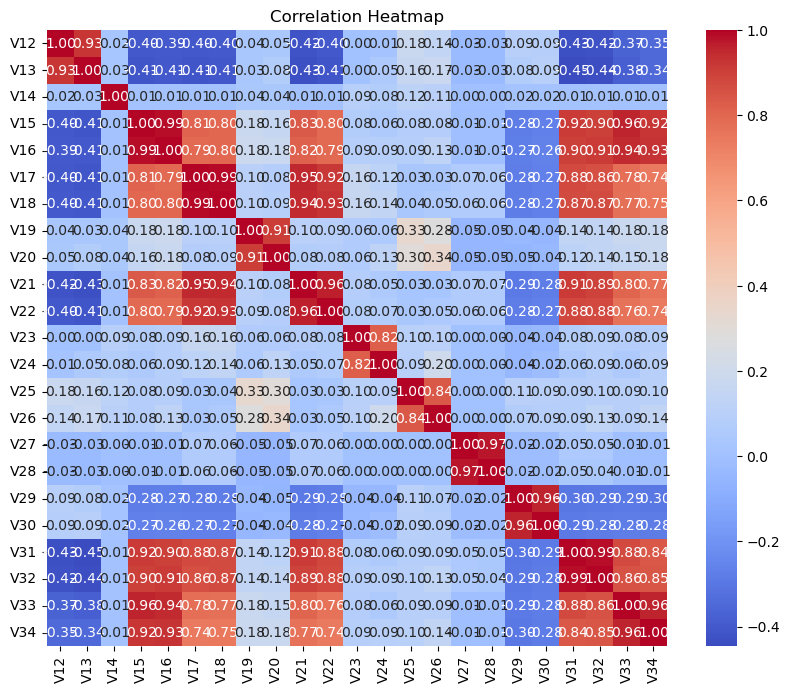

Cols with same number of NaNs: ['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']

Cols that are highly corrlated to each other: [['V35', 'V36'], ['V37', 'V38'], ['V39', 'V40', 'V42', 'V43', 'V50', 'V51', 'V52'], ['V41'], ['V44', 'V45'], ['V46', 'V47'], ['V48', 'V49']]

Selected columns: ['V36', 'V38', 'V52', 'V41', 'V45', 'V47', 'V49']


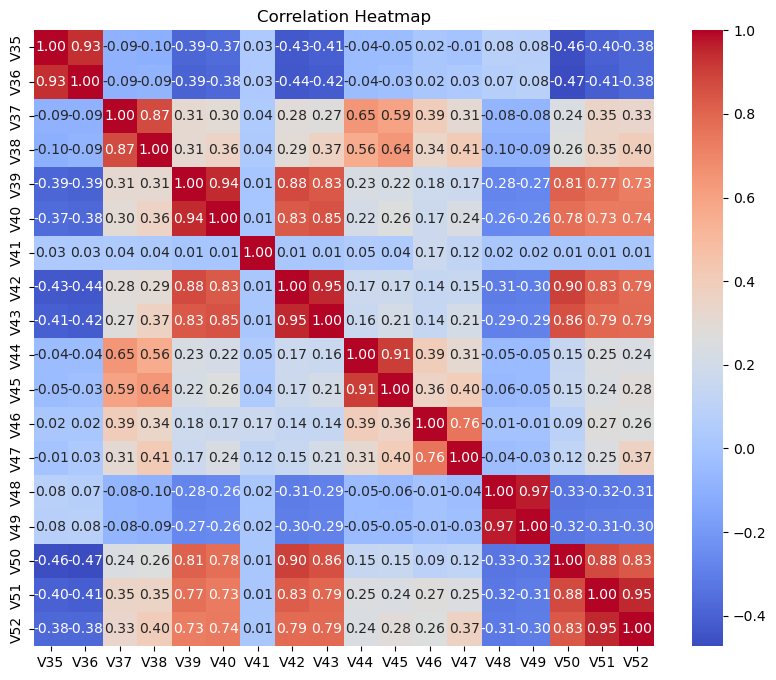

Cols with same number of NaNs: ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']

Cols that are highly corrlated to each other: [['V53', 'V54'], ['V55'], ['V56'], ['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'], ['V61', 'V62'], ['V65'], ['V66', 'V67'], ['V68'], ['V69', 'V70']]

Selected columns: ['V54', 'V55', 'V56', 'V74', 'V62', 'V65', 'V67', 'V68', 'V70']


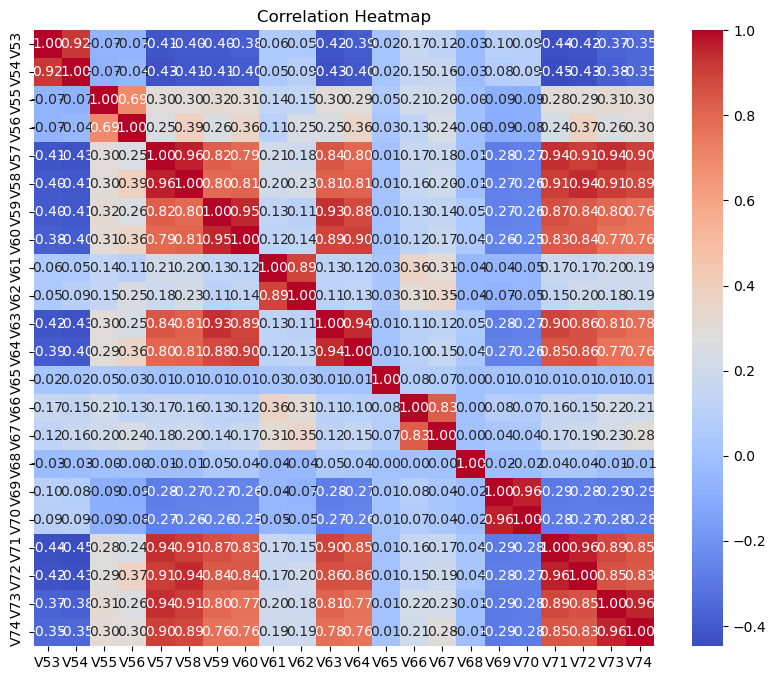

Cols with same number of NaNs: ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']

Cols that are highly corrlated to each other: [['V75', 'V76'], ['V77', 'V78'], ['V79', 'V80', 'V81', 'V84', 'V85', 'V92', 'V93', 'V94'], ['V82', 'V83'], ['V86', 'V87'], ['V88'], ['V89'], ['V90', 'V91']]

Selected columns: ['V76', 'V78', 'V94', 'V83', 'V87', 'V88', 'V89', 'V91']


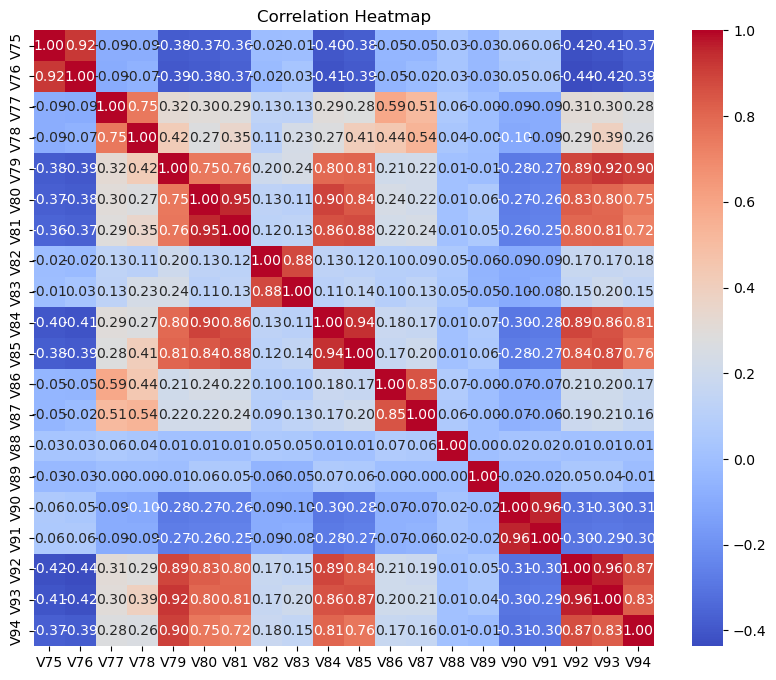

Cols with same number of NaNs: ['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']

Cols that are highly corrlated to each other: [['V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134'], ['V98'], ['V99', 'V100'], ['V104'], ['V107'], ['V108', 'V110', 'V114'], ['V109'], ['V111', 'V112', 'V113'], ['V115', 'V116'], ['V117', 'V119'], ['V118'], ['V120', 'V122'], ['V121'], ['V123', 'V125'], ['V124'], ['V129', 'V131'], ['V130'], ['V135', 'V136', 'V137']]

Selected columns: ['V134', 'V98', 'V100', 'V104', 'V107', 'V114', 'V109', 'V113', 'V116', 'V119', 'V118', 'V122', 'V121', 'V125', 'V124', 'V131', 'V130', 'V137']


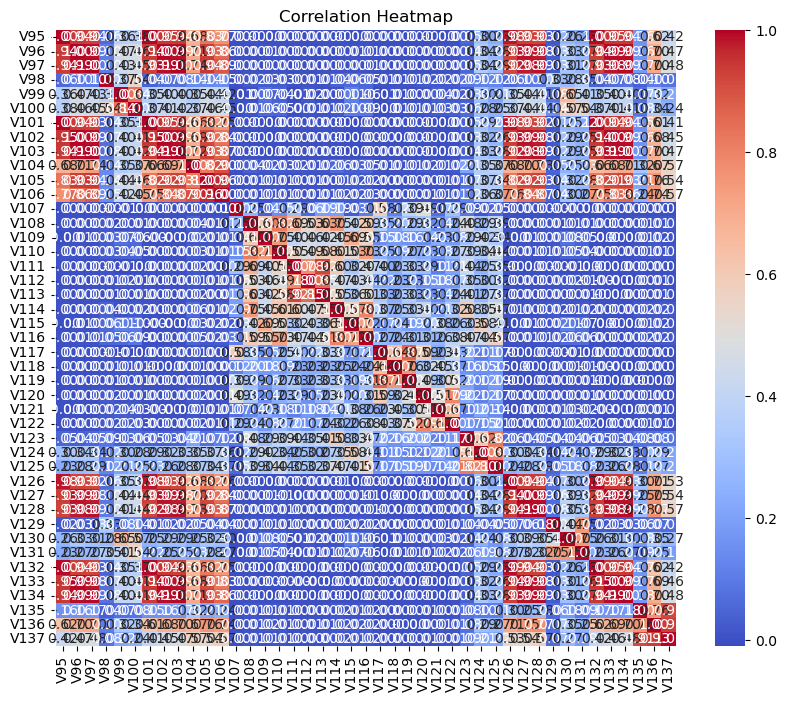

Cols with same number of NaNs: ['V279', 'V280', 'V284', 'V285', 'V286', 'V287', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']

Cols that are highly corrlated to each other: [['V279', 'V280', 'V293', 'V294', 'V295', 'V298', 'V299', 'V306', 'V307', 'V308', 'V316', 'V317', 'V318'], ['V284'], ['V285', 'V287'], ['V286'], ['V290', 'V291', 'V292'], ['V297'], ['V302', 'V303', 'V304'], ['V305'], ['V309', 'V311', 'V312'], ['V310'], ['V319', 'V320', 'V321']]

Selected columns: ['V318', 'V284', 'V287', 'V286', 'V292', 'V297', 'V304', 'V305', 'V312', 'V310', 'V321']


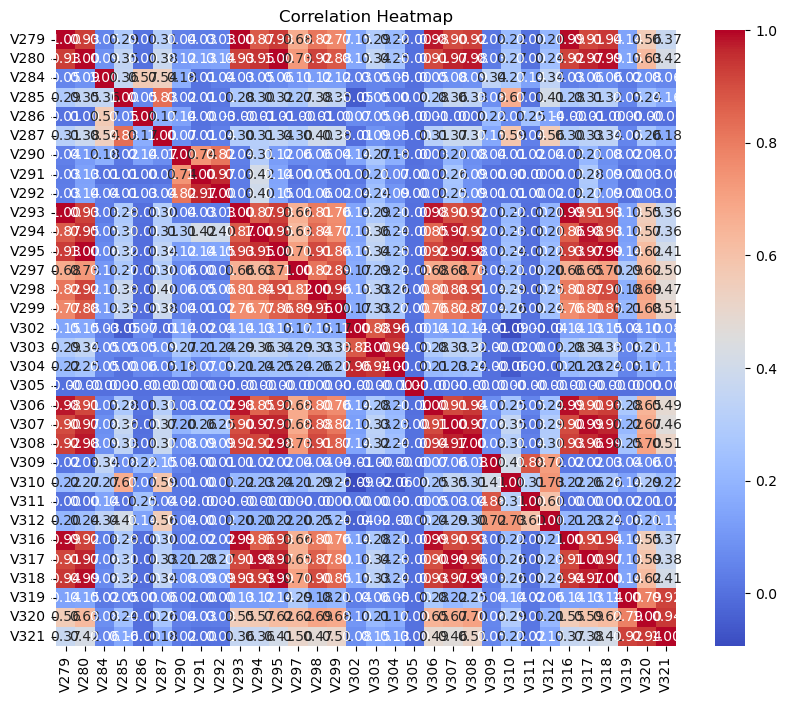

In [6]:
# we do so for all the groups in nans_group
v_cols = []

for group in nans_group:
    print("Cols with same number of NaNs:", group)
    group_df = train[group]
    correlation_matrix = group_df.corr()
    
    # Assuming you have the correlation matrix 'correlation_matrix'
    # Define the correlation threshold
    correlation_threshold = 0.7

    # Find correlated groups
    correlation_groups = find_correlation_groups(correlation_matrix, correlation_threshold)
    print("\nCols that are highly corrlated to each other:", correlation_groups)

    reduced_groups = reduce_groups(correlation_groups)
    v_cols.extend(reduced_groups)
    print("\nSelected columns:", reduced_groups)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

In [7]:
# Cleaning up of v columns

v_cols = [i for i in v_cols if 'V' in i]
print(len(v_cols), 'out of', len(i_cols), 'V columns chosen')

def extract_integer_portion(s):
    # Use regular expression to extract the integer portion of the string
    match = re.search(r'\d+', s)
    if match:
        return int(match.group())
    else:
        return 0  # Return 0 if no integer portion is found

v_cols = sorted(v_cols, key=extract_integer_portion)
print(v_cols)

del train; x = gc.collect()

73 out of 339 V columns chosen
['V1', 'V5', 'V7', 'V8', 'V9', 'V11', 'V13', 'V14', 'V20', 'V24', 'V26', 'V28', 'V30', 'V34', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V55', 'V56', 'V62', 'V65', 'V67', 'V68', 'V70', 'V74', 'V76', 'V78', 'V83', 'V87', 'V88', 'V89', 'V91', 'V94', 'V98', 'V100', 'V104', 'V107', 'V109', 'V113', 'V114', 'V116', 'V118', 'V119', 'V121', 'V122', 'V124', 'V125', 'V130', 'V131', 'V134', 'V137', 'V281', 'V283', 'V284', 'V286', 'V287', 'V289', 'V292', 'V296', 'V297', 'V301', 'V304', 'V305', 'V310', 'V312', 'V315', 'V318', 'V321']


## Importing of other datasets

Having selected our V columns above, we will now be moving on with importing all our essential datasets with only the cleaned up V columns to reduced memory usage and improve performance.

In [8]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

cols.extend(v_cols)
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: 
    dtypes[c] = 'category'
    
print('Columns to be read:', cols)

Columns to be read: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V5', 'V7', 'V8', 'V9', 'V11', 'V13', 'V14', 'V20', 'V24', 'V26', 'V28', 'V30', 'V34', 'V36', 'V38', 'V41', 'V45', 'V47', 'V49', 'V52', 'V54', 'V55', 'V56', 'V62', 'V65', 'V67', 'V68', 'V70', 'V74', 'V76', 'V78', 'V83', 'V87', 'V88', 'V89', 'V91', 'V94', 'V98', 'V100', 'V104', 'V107', 'V109', 'V113', 'V114', 'V116', 'V118', 'V119', 'V121', 'V122', 'V124', 'V125', 'V130', 'V131', 'V134', 'V137', 'V281', 'V283', 'V284', 'V286', 'V287', 'V289', 'V292', 'V296', 'V297', 'V301', 'V304', 'V305', 'V310', 'V312', 'V315', 'V318', 'V321']


In [9]:
%%time

### Sheng Yang ###
# # LOAD TRAIN
# X_train = pd.read_csv('../data/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
# train_id = pd.read_csv('../data/train_identity.csv',index_col='TransactionID', dtype=dtypes)
# X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

# # LOAD TEST
# X_test = pd.read_csv('../data/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
# test_id = pd.read_csv('../data/test_identity.csv',index_col='TransactionID', dtype=dtypes)

### HX ###
# LOAD TRAIN
X_train = pd.read_csv('./train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('./train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('./test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('./test_identity.csv',index_col='TransactionID', dtype=dtypes)

fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

# DISTRIBUTION OF Y_TRAIN
print(y_train.value_counts(dropna=False))

Train shape (590540, 166) test shape (506691, 166)
isFraud
0    569877
1     20663
Name: count, dtype: int64
CPU times: user 8.23 s, sys: 863 ms, total: 9.09 s
Wall time: 9.32 s


# Missing Values

In [10]:
def top_missing_cols(df,thresh,n=10):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    return dff[dff["missing_percent"] > thresh]

In [11]:
print('Missing Values Analysis for Train Dataset:')
df_missing_values_train = top_missing_cols(X_train,70)
print('\n')
print('Missing Values Analysis for Test Dataset:')
df_missing_values_test = top_missing_cols(X_test,70)

Missing Values Analysis for Train Dataset:
There are 148 columns in this dataset with missing values.
There are 49 columns with missing percent values than 70%


Missing Values Analysis for Test Dataset:
There are 144 columns in this dataset with missing values.
There are 49 columns with missing percent values than 70%


The train and test sets both have the same columns with more than **70%** of its values missing. We will drop the same columns from both the train and test sets. 

In [12]:
cols_to_drop = df_missing_values_train['col'].unique()
X_train.drop(columns = cols_to_drop, inplace = True)
X_test.drop(columns = cols_to_drop, inplace = True)
print('Train dimensions:', X_train.shape)
print('Test dimensions:', X_test.shape)

Train dimensions: (590540, 117)
Test dimensions: (506691, 117)


With 101 features removed in both train and test, the remaining 112 features would have less than 70% missing values.

In [13]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test))

Number of missing columns in train dataset:  99
Number of missing columns in test dataset:  95


In [14]:
for col in cols_with_missing_train:
    print(col, ":",(X_train[col].isna().mean() * 100).round(2))

card2 : 1.51
card3 : 0.27
card4 : 0.27
card5 : 0.72
card6 : 0.27
addr1 : 11.13
addr2 : 11.13
dist1 : 59.65
P_emaildomain : 15.99
D1 : 0.21
D2 : 47.55
D3 : 44.51
D4 : 28.6
D5 : 52.47
D10 : 12.87
D11 : 47.29
D15 : 15.09
M1 : 45.91
M2 : 45.91
M3 : 45.91
M4 : 47.66
M5 : 59.35
M6 : 28.68
M7 : 58.64
M8 : 58.63
M9 : 58.63
V1 : 47.29
V5 : 47.29
V7 : 47.29
V8 : 47.29
V9 : 47.29
V11 : 47.29
V13 : 12.88
V14 : 12.88
V20 : 12.88
V24 : 12.88
V26 : 12.88
V28 : 12.88
V30 : 12.88
V34 : 12.88
V36 : 28.61
V38 : 28.61
V41 : 28.61
V45 : 28.61
V47 : 28.61
V49 : 28.61
V52 : 28.61
V54 : 13.06
V55 : 13.06
V56 : 13.06
V62 : 13.06
V65 : 13.06
V67 : 13.06
V68 : 13.06
V70 : 13.06
V74 : 13.06
V76 : 15.1
V78 : 15.1
V83 : 15.1
V87 : 15.1
V88 : 15.1
V89 : 15.1
V91 : 15.1
V94 : 15.1
V98 : 0.05
V100 : 0.05
V104 : 0.05
V107 : 0.05
V109 : 0.05
V113 : 0.05
V114 : 0.05
V116 : 0.05
V118 : 0.05
V119 : 0.05
V121 : 0.05
V122 : 0.05
V124 : 0.05
V125 : 0.05
V130 : 0.05
V131 : 0.05
V134 : 0.05
V137 : 0.05
V281 : 0.21
V283 : 0.21
V

In [15]:
for col in cols_with_missing_test:
    print(col, ":",(X_test[col].isna().mean() * 100).round(2))

card2 : 1.71
card3 : 0.59
card4 : 0.61
card5 : 0.9
card6 : 0.59
addr1 : 12.95
addr2 : 12.95
dist1 : 57.47
P_emaildomain : 13.66
C1 : 0.0
C2 : 0.0
C3 : 0.0
C4 : 0.0
C5 : 0.0
C6 : 0.0
C7 : 0.0
C8 : 0.0
C9 : 0.0
C10 : 0.0
C11 : 0.0
C12 : 0.0
C13 : 0.94
C14 : 0.0
D1 : 1.19
D2 : 46.33
D3 : 40.09
D4 : 15.17
D5 : 44.28
D10 : 2.48
D11 : 34.84
D15 : 2.38
M1 : 34.86
M2 : 34.86
M3 : 34.86
M4 : 46.92
M5 : 61.11
M6 : 31.37
M7 : 46.38
M8 : 46.38
M9 : 46.38
V1 : 34.84
V5 : 34.84
V7 : 34.84
V8 : 34.84
V9 : 34.84
V11 : 34.84
V13 : 2.48
V14 : 2.48
V20 : 2.48
V24 : 2.48
V26 : 2.48
V28 : 2.48
V30 : 2.48
V34 : 2.48
V36 : 15.17
V38 : 15.17
V41 : 15.17
V45 : 15.17
V47 : 15.17
V49 : 15.17
V52 : 15.17
V54 : 2.55
V55 : 2.55
V56 : 2.55
V62 : 2.55
V65 : 2.55
V67 : 2.55
V68 : 2.55
V70 : 2.55
V74 : 2.55
V76 : 2.38
V78 : 2.38
V83 : 2.38
V87 : 2.38
V88 : 2.38
V89 : 2.38
V91 : 2.38
V94 : 2.38
V281 : 1.19
V283 : 1.19
V284 : 0.0
V286 : 0.0
V287 : 0.0
V289 : 1.19
V292 : 0.0
V296 : 1.19
V297 : 0.0
V301 : 1.19
V304 : 0.0
V

# Removal of Rows
We first filter out rows with **less than 2%** of missing values in each column. Then, we remove those rows with missing values in those columns.

In [16]:
small_cols = []
for col in cols_with_missing_train:
    if (X_train[col].isna().mean() * 100).round(2) < 2 :
        small_cols.append(col)
        
small_cols

['card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'D1',
 'V98',
 'V100',
 'V104',
 'V107',
 'V109',
 'V113',
 'V114',
 'V116',
 'V118',
 'V119',
 'V121',
 'V122',
 'V124',
 'V125',
 'V130',
 'V131',
 'V134',
 'V137',
 'V281',
 'V283',
 'V284',
 'V286',
 'V287',
 'V289',
 'V292',
 'V296',
 'V297',
 'V301',
 'V304',
 'V305',
 'V310',
 'V312',
 'V315',
 'V318',
 'V321']

In [17]:
train_merge = pd.concat([X_train, y_train], axis=1).rename(columns={0:'isFraud'})
X_train = train_merge.dropna(subset = small_cols).drop('isFraud', axis=1)
y_train = train_merge.dropna(subset = small_cols)['isFraud']
# X_train = X_train.dropna(subset = small_cols)
X_test = X_test.dropna(subset = small_cols)

print("Number of columns in train dataset:",X_train.shape)
print("Number of columns in test dataset:",X_test.shape)

cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test))
print('Distribution of y_train:', y_train.value_counts(dropna=False))

Number of columns in train dataset: (578081, 117)
Number of columns in test dataset: (491009, 117)
Number of missing columns in train dataset:  58
Number of missing columns in test dataset:  72
Distribution of y_train: isFraud
0    558065
1     20016
Name: count, dtype: int64


# Exploring Distribution of D Columns 

In [18]:
remaining_cols = [item for item in cols_with_missing_train if item not in small_cols]
D_columns = []
for col in remaining_cols:
    if 'D' in col:
        D_columns.append(col)
D_columns

['D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']

Distribution of D columns

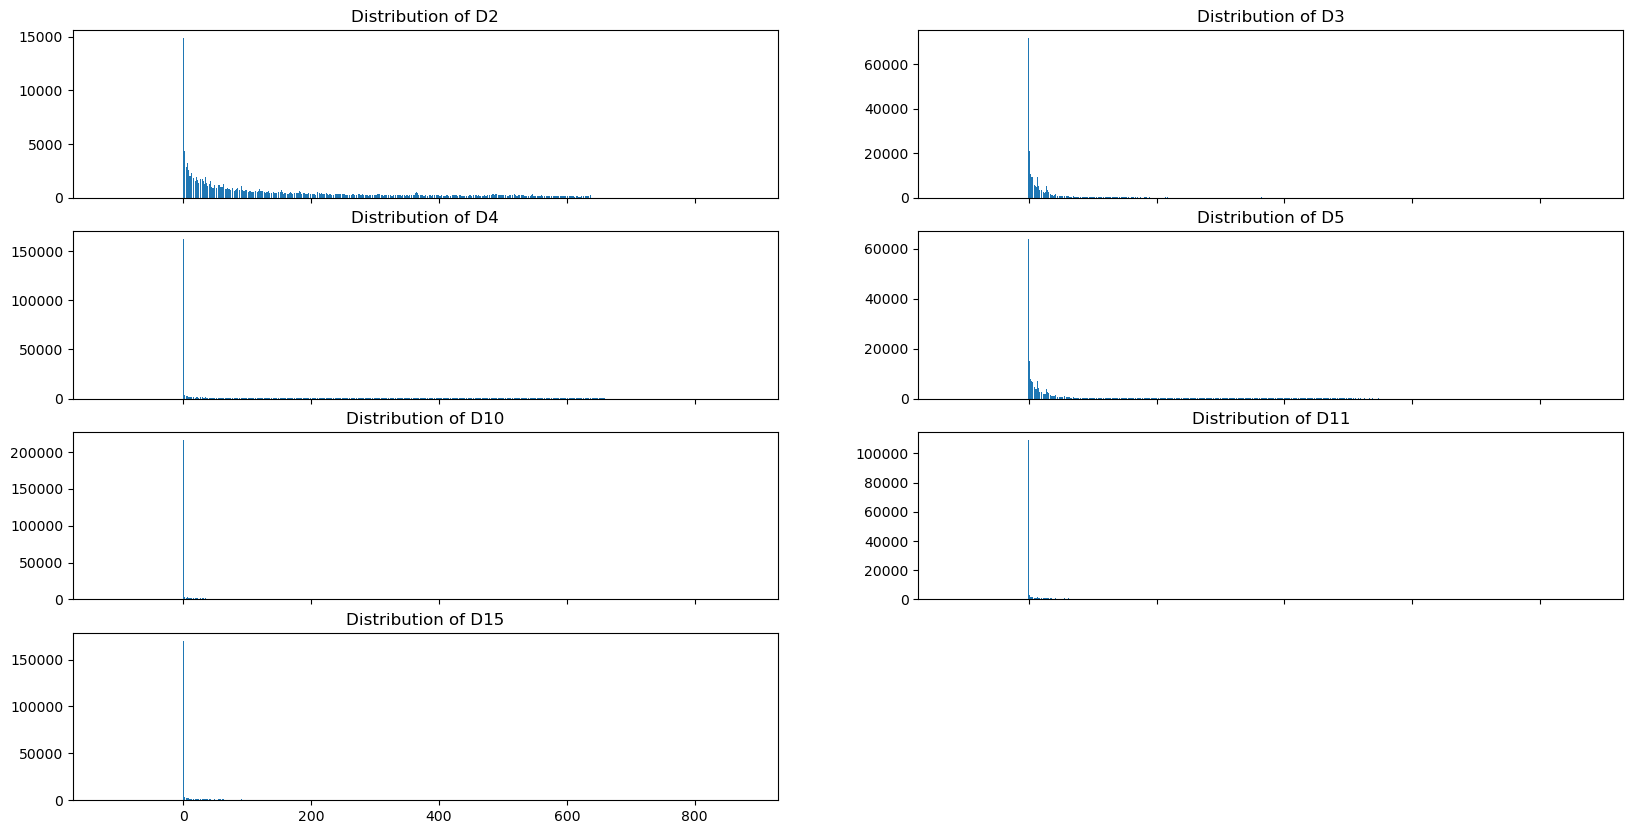

In [19]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,10), sharex = True)

value_counts_D2 = X_train['D2'].value_counts()
axes[0,0].bar(value_counts_D2.index, value_counts_D2.values)
axes[0,0].set_title("Distribution of D2")

value_counts_D3 = X_train['D3'].value_counts()
axes[0,1].bar(value_counts_D3.index, value_counts_D3.values)
axes[0,1].set_title("Distribution of D3")

value_counts_D4 = X_train['D4'].value_counts()
axes[1,0].bar(value_counts_D4.index, value_counts_D4.values)
axes[1,0].set_title("Distribution of D4")

value_counts_D5 = X_train['D5'].value_counts()
axes[1,1].bar(value_counts_D5.index, value_counts_D5.values)
axes[1,1].set_title("Distribution of D5")

value_counts_D10 = X_train['D10'].value_counts()
axes[2,0].bar(value_counts_D10.index, value_counts_D10.values)
axes[2,0].set_title("Distribution of D10")

value_counts_D11 = X_train['D11'].value_counts()
axes[2,1].bar(value_counts_D11.index, value_counts_D11.values)
axes[2,1].set_title("Distribution of D11")

value_counts_D15 = X_train['D15'].value_counts()
axes[3,0].bar(value_counts_D15.index, value_counts_D15.values)
axes[3,0].set_title("Distribution of D15")

axes[3,1].axis('off')
plt.show()

Decision: 
- We will fill up the columns of **D2, D4, D10, D15** with its mode value as the distribution of these columns' values seems left-skewed.
- We will fill up the columns of **D3, D5 and D11** with its mean value as the distribution of these columns' values seems evenly distributed. 

In [20]:
# fill up D3, D5, D11 with means
mean = X_train[['D3','D5','D11']].mean()
X_train[['D3','D5','D11']] = X_train[['D3','D5','D11']].fillna(mean[['D3','D5','D11']])
X_test[['D3','D5','D11']] = X_test[['D3','D5','D11']].fillna(mean[['D3','D5','D11']])

In [21]:
# fill up D2, D4, D10, D15 with modes
mode_train = X_train.mode().iloc[0]
mode_test = X_test.mode().iloc[0]

D_columns_mode = ['D2','D4','D10','D15']
X_train[D_columns_mode] = X_train[D_columns_mode].fillna(mode_train[D_columns_mode])
X_test[D_columns_mode] = X_test[D_columns_mode].fillna(mode_test[D_columns_mode])

In [22]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test))

Number of missing columns in train dataset:  51
Number of missing columns in test dataset:  65


# Exploring Distribution of M Columns

In [23]:
M_columns = []
for col in remaining_cols:
    if 'M' in col:
        M_columns.append(col)
M_columns

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

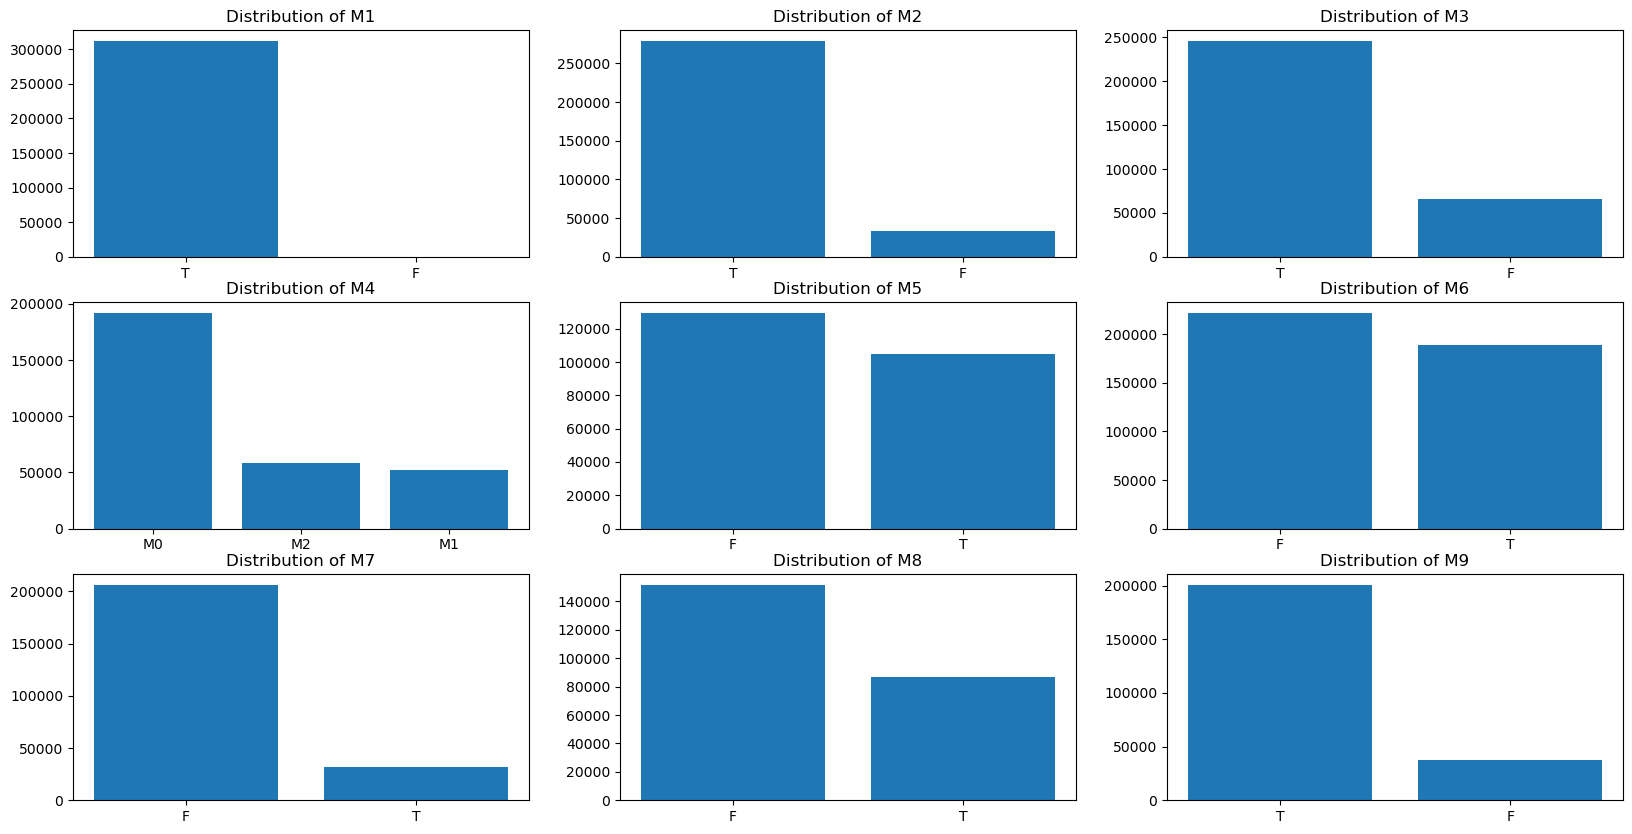

In [24]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20,10))

value_counts_M1 = X_train['M1'].value_counts()
axes[0,0].bar(value_counts_M1.index, value_counts_M1.values)
axes[0,0].set_title("Distribution of M1")

value_counts_M2 = X_train['M2'].value_counts()
axes[0,1].bar(value_counts_M2.index, value_counts_M2.values)
axes[0,1].set_title("Distribution of M2")

value_counts_M3 = X_train['M3'].value_counts()
axes[0,2].bar(value_counts_M3.index, value_counts_M3.values)
axes[0,2].set_title("Distribution of M3")

value_counts_M4 = X_train['M4'].value_counts()
axes[1,0].bar(value_counts_M4.index, value_counts_M4.values)
axes[1,0].set_title("Distribution of M4")

value_counts_M5 = X_train['M5'].value_counts()
axes[1,1].bar(value_counts_M5.index, value_counts_M5.values)
axes[1,1].set_title("Distribution of M5")

value_counts_M6 = X_train['M6'].value_counts()
axes[1,2].bar(value_counts_M6.index, value_counts_M6.values)
axes[1,2].set_title("Distribution of M6")

value_counts_M7 = X_train['M7'].value_counts()
axes[2,0].bar(value_counts_M7.index, value_counts_M7.values)
axes[2,0].set_title("Distribution of M7")

value_counts_M8 = X_train['M8'].value_counts()
axes[2,1].bar(value_counts_M8.index, value_counts_M8.values)
axes[2,1].set_title("Distribution of M8")

value_counts_M9 = X_train['M9'].value_counts()
axes[2,2].bar(value_counts_M9.index, value_counts_M9.values)
axes[2,2].set_title("Distribution of M9")

plt.show()

Decision:
- We will fill the columns **M1, M2, M3, M4, M7, M8, M9** with their mode value as the distribution is heavily imbalanced. Hence, filling the missing values with the mode value will not changle the inherent distribution of these column
- For columns **M5, M6**, we will fill up the missing values by randomly allocating the 2 possible values. 

In [25]:
M_columns_mode = ['M1','M2','M3','M4','M7','M8','M9']
X_train[M_columns_mode] = X_train[M_columns_mode].fillna(mode_train[M_columns_mode])
X_test[M_columns_mode] = X_test[M_columns_mode].fillna(mode_test[M_columns_mode])

In [26]:
def allocate_missing_values(value1, value2):
    return np.random.choice([value1, value2], size=1)[0]

In [27]:
for column in ['M5','M6']:
    if X_train[column].isna().any():
        missing_mask = X_train[column].isna()
        values = X_train[column].dropna().unique()
        allocated_values = np.array([allocate_missing_values(*values) for _ in range(missing_mask.sum())])
        X_train.loc[missing_mask, column] = allocated_values

for column in ['M5','M6']:
    if X_test[column].isna().any():
        missing_mask = X_test[column].isna()
        values = X_test[column].dropna().unique()
        allocated_values = np.array([allocate_missing_values(*values) for _ in range(missing_mask.sum())])
        X_test.loc[missing_mask, column] = allocated_values

In [28]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in train dataset:  42
Number of missing columns in test dataset:  56


# Exploring Distribution of V Columns

In [29]:
V_columns = []
for col in remaining_cols:
    if 'V' in col:
        V_columns.append(col)
V_columns

['V1',
 'V5',
 'V7',
 'V8',
 'V9',
 'V11',
 'V13',
 'V14',
 'V20',
 'V24',
 'V26',
 'V28',
 'V30',
 'V34',
 'V36',
 'V38',
 'V41',
 'V45',
 'V47',
 'V49',
 'V52',
 'V54',
 'V55',
 'V56',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V74',
 'V76',
 'V78',
 'V83',
 'V87',
 'V88',
 'V89',
 'V91',
 'V94']

Decision:
- We will fill up the missing values of the V Columns with its **respective mode value.** 

In [30]:
X_train[V_columns] = X_train[V_columns].fillna(mode_train[V_columns])
X_test[V_columns] = X_test[V_columns].fillna(mode_test[V_columns])

cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in train dataset:  4
Number of missing columns in test dataset:  18


# Exploring Other Columns

In [31]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_train

['addr1', 'addr2', 'dist1', 'P_emaildomain']

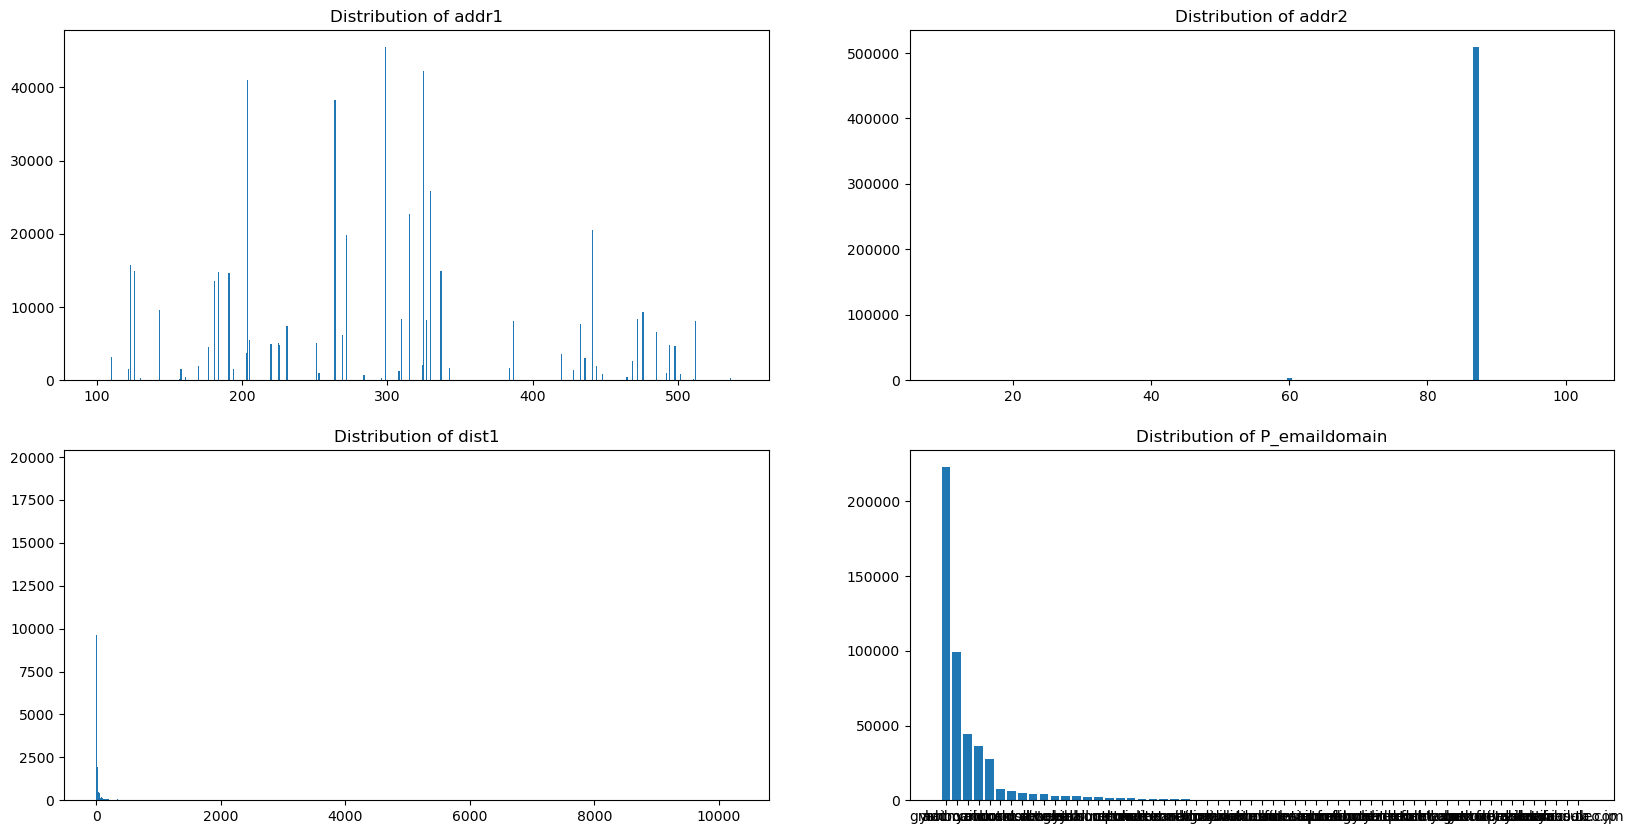

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10))

value_counts_addr1 = X_train['addr1'].value_counts()
axes[0,0].bar(value_counts_addr1.index, value_counts_addr1.values)
axes[0,0].set_title("Distribution of addr1")

value_counts_addr2 = X_train['addr2'].value_counts()
axes[0,1].bar(value_counts_addr2.index, value_counts_addr2.values)
axes[0,1].set_title("Distribution of addr2")

value_counts_dist1 = X_train['dist1'].value_counts()
axes[1,0].bar(value_counts_dist1.index, value_counts_dist1.values)
axes[1,0].set_title("Distribution of dist1")

value_counts_P_emaildomain = X_train['P_emaildomain'].value_counts()
axes[1,1].bar(value_counts_P_emaildomain.index, value_counts_P_emaildomain.values)
axes[1,1].set_title("Distribution of P_emaildomain")

plt.show()

Decision:
- We will fill the missing values of addr1 with its **mean value**.
- We will fill the missing values of addr2, dist1 and P_emaildomain with its **mode values**.

In [33]:
X_train['addr1'] = X_train['addr1'].fillna(np.mean(X_train['addr1']))
X_train[['addr2', 'dist1', 'P_emaildomain']] = X_train[['addr2', 'dist1', 'P_emaildomain']].fillna(mode_train[['addr2', 'dist1', 'P_emaildomain']])

cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in train dataset:  0
Number of missing columns in test dataset:  18


Now we need to work on filling remaining NA values for test dataset 

In [34]:
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
cols_with_missing_test

['addr1',
 'addr2',
 'dist1',
 'P_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [35]:
for col in cols_with_missing_test:
    print(col, ":",(X_test[col].isna().mean() * 100).round(2))

addr1 : 12.87
addr2 : 12.87
dist1 : 56.86
P_emaildomain : 13.75
C1 : 0.0
C2 : 0.0
C3 : 0.0
C4 : 0.0
C5 : 0.0
C6 : 0.0
C7 : 0.0
C8 : 0.0
C9 : 0.0
C10 : 0.0
C11 : 0.0
C12 : 0.0
C13 : 0.62
C14 : 0.0


We will remove the rows with missing values in these columns.

In [36]:
X_test.dropna(subset = cols_with_missing_test, inplace = True)
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in test dataset:  0


In [37]:
pd.concat([X_train,y_train], axis=1).to_csv('train_preprocessed.csv')

In [38]:
X_test.to_csv('test_preprocessed.csv')